In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

train_df = pd.read_csv('kaggle-tabular-playground-series-aug-2022/train.csv')
test_df = pd.read_csv('kaggle-tabular-playground-series-aug-2022/test.csv')

In [2]:
# Prepare the data
X = train_df.drop(['id', 'failure'], axis=1)
y = train_df['failure']

# Define categorical variables
categorical_features = ['product_code', 'attribute_0', 'attribute_1']

# Handle categorical variables with one-hot encoding
X = pd.get_dummies(X, columns=categorical_features)

# Define numeric features (all columns that are not categorical)
numeric_features = [col for col in X.columns if not any(col.startswith(cat_feat) for cat_feat in categorical_features)]

# Impute numeric features with median
numeric_imputer = SimpleImputer(strategy='median')
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

# No need to impute categorical features as they've been one-hot encoded

print(f"Shape of X after imputation: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Score the model
accuracy = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Prepare the final validation data (test_df)
X_final = test_df.drop('id', axis=1)
X_final = pd.get_dummies(X_final, columns=categorical_features)

# Impute missing values in the final validation data
# Impute numeric features with median from the training data to avoid data leakage
X_final.columns
X_final[numeric_features] = numeric_imputer.transform(X_final[numeric_features])

print(f"Shape of X_final: {X_final.shape}")

# Ensure X_final has the same columns as X_train
for col in X_train.columns:
    if col not in X_final.columns:
        X_final[col] = 0
X_final = X_final[X_train.columns]

# Make predictions on the final validation data
final_predictions = model.predict(X_final)

# Create a submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'failure': final_predictions
})

# Save the submission file
submission.to_csv('logistic_regression_submission.csv', index=False)
print("\nSubmission file created: logistic_regression_submission.csv")


Shape of X after imputation: (26570, 31)
Shape of y: (26570,)
Accuracy: 0.5012

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4257
           1       0.40      0.00      0.01      1057

    accuracy                           0.80      5314
   macro avg       0.60      0.50      0.45      5314
weighted avg       0.72      0.80      0.71      5314

Shape of X_final: (20775, 30)

Submission file created: logistic_regression_submission.csv


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Percent of failures: 0.19890854347007902
Percent of non-failures: 0.801091456529921


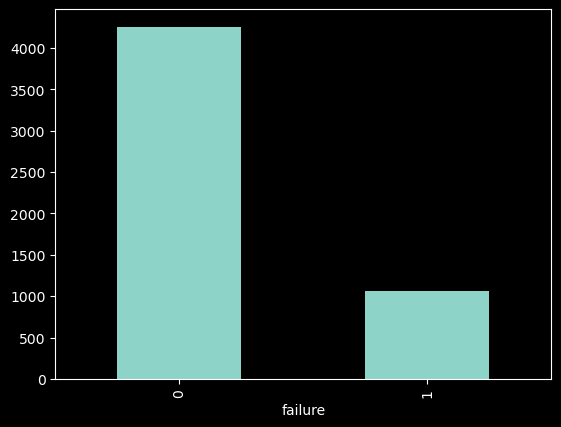

In [3]:
y_test.value_counts().plot.bar()
y_test.value_counts()

print(f"Percent of failures: {y_test.value_counts()[1] / y_test.value_counts().sum()}")
print(f"Percent of non-failures: {y_test.value_counts()[0] / y_test.value_counts().sum()}")

In [4]:
# Try oversampling the minority class

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and apply the oversampling
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Original dataset shape:", X_train.shape, y_train.shape)
print("Resampled dataset shape:", X_train_resampled.shape, y_train_resampled.shape)

# Print the old class distribution
print("\nOld class distribution:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

# Print the new class distribution
print("\nNew class distribution:")
print(y_train_resampled.value_counts())
print(y_train_resampled.value_counts(normalize=True))

# Train a new model on the resampled data
model_resampled = LogisticRegression(random_state=42)
model_resampled.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_resampled = model_resampled.predict(X_test)

# Calculate accuracy
accuracy_resampled = roc_auc_score(y_test, y_pred_resampled)
print(f"\nAccuracy with resampled data: {accuracy_resampled:.4f}")

# Print classification report
print("\nClassification Report with resampled data:")
print(classification_report(y_test, y_pred_resampled))


Original dataset shape: (21256, 31) (21256,)
Resampled dataset shape: (33328, 31) (33328,)

Old class distribution:
failure
0    16664
1     4592
Name: count, dtype: int64
failure
0    0.783967
1    0.216033
Name: proportion, dtype: float64

New class distribution:
failure
0    16664
1    16664
Name: count, dtype: int64
failure
0    0.5
1    0.5
Name: proportion, dtype: float64

Accuracy with resampled data: 0.5625

Classification Report with resampled data:
              precision    recall  f1-score   support

           0       0.84      0.61      0.70      4257
           1       0.25      0.52      0.33      1057

    accuracy                           0.59      5314
   macro avg       0.54      0.56      0.52      5314
weighted avg       0.72      0.59      0.63      5314



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
# Use LogisticRegressionCV to find the best hyperparameters

# Define the parameter grid for LogisticRegressionCV
Cs = np.logspace(-4, 4, 20)

# Initialize LogisticRegressionCV with 5-fold cross-validation
lr_cv = LogisticRegressionCV(cv=5, Cs=Cs, scoring='roc_auc', random_state=42, max_iter=1000)

# Fit the model on the training data
lr_cv.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print(f"\nBest hyperparameters: {lr_cv.C_}")

# Make predictions on the test set
y_pred_cv = lr_cv.predict(X_test)

# Calculate accuracy
accuracy_cv = roc_auc_score(y_test, y_pred_cv)
print(f"\nAccuracy with cross-validation: {accuracy_cv:.4f}")


Best hyperparameters: [0.00069519]

Accuracy with cross-validation: 0.5640


In [6]:
# Prepare the data
X = train_df.drop(['id', 'failure'], axis=1)
y = train_df['failure']

# Define categorical variables
categorical_features = ['product_code', 'attribute_0', 'attribute_1']

# Handle categorical variables with one-hot encoding
X = pd.get_dummies(X, columns=categorical_features)

# Define numeric features (all columns that are not categorical)
numeric_features = [col for col in X.columns if not any(col.startswith(cat_feat) for cat_feat in categorical_features)]

# Impute numeric features with median
numeric_imputer = KNNImputer(n_neighbors=5)
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

# No need to impute categorical features as they've been one-hot encoded

print(f"Shape of X after imputation: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Score the model
accuracy = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# # Prepare the final validation data (test_df)
# X_final = test_df.drop('id', axis=1)
# X_final = pd.get_dummies(X_final, columns=categorical_features)

# # Impute missing values in the final validation data
# # Impute numeric features with median from the training data to avoid data leakage
# X_final.columns
# X_final[numeric_features] = numeric_imputer.transform(X_final[numeric_features])

# print(f"Shape of X_final: {X_final.shape}")

# # Ensure X_final has the same columns as X_train
# for col in X_train.columns:
#     if col not in X_final.columns:
#         X_final[col] = 0
# X_final = X_final[X_train.columns]

# # Make predictions on the final validation data
# final_predictions = model.predict(X_final)

# # Create a submission dataframe
# submission = pd.DataFrame({
#     'id': test_df['id'],
#     'failure': final_predictions
# })

# # Save the submission file
# submission.to_csv('logistic_regression_submission.csv', index=False)
# print("\nSubmission file created: logistic_regression_submission.csv")


Shape of X after imputation: (26570, 31)
Shape of y: (26570,)
Accuracy: 0.5012

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4257
           1       0.40      0.00      0.01      1057

    accuracy                           0.80      5314
   macro avg       0.60      0.50      0.45      5314
weighted avg       0.72      0.80      0.71      5314



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
# Run sequential feature selection

# Initialize SequentialFeatureSelector with LogisticRegression as the estimator
sfs = SequentialFeatureSelector(LogisticRegression(random_state=42), n_features_to_select=10, direction='forward')

# Fit the selector on the training data
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[sfs.get_support()]

print("Selected features:", selected_features)

# Transform the training and test data using the selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Train a new model on the selected features
model_selected = LogisticRegression(random_state=42)
model_selected.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_selected = model_selected.predict(X_test_selected)

# Calculate accuracy
accuracy_selected = roc_auc_score(y_test, y_pred_selected)
print(f"\nAccuracy with selected features: {accuracy_selected:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Selected features: Index(['attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7'],
      dtype='object')

Accuracy with selected features: 0.5000


<Axes: >

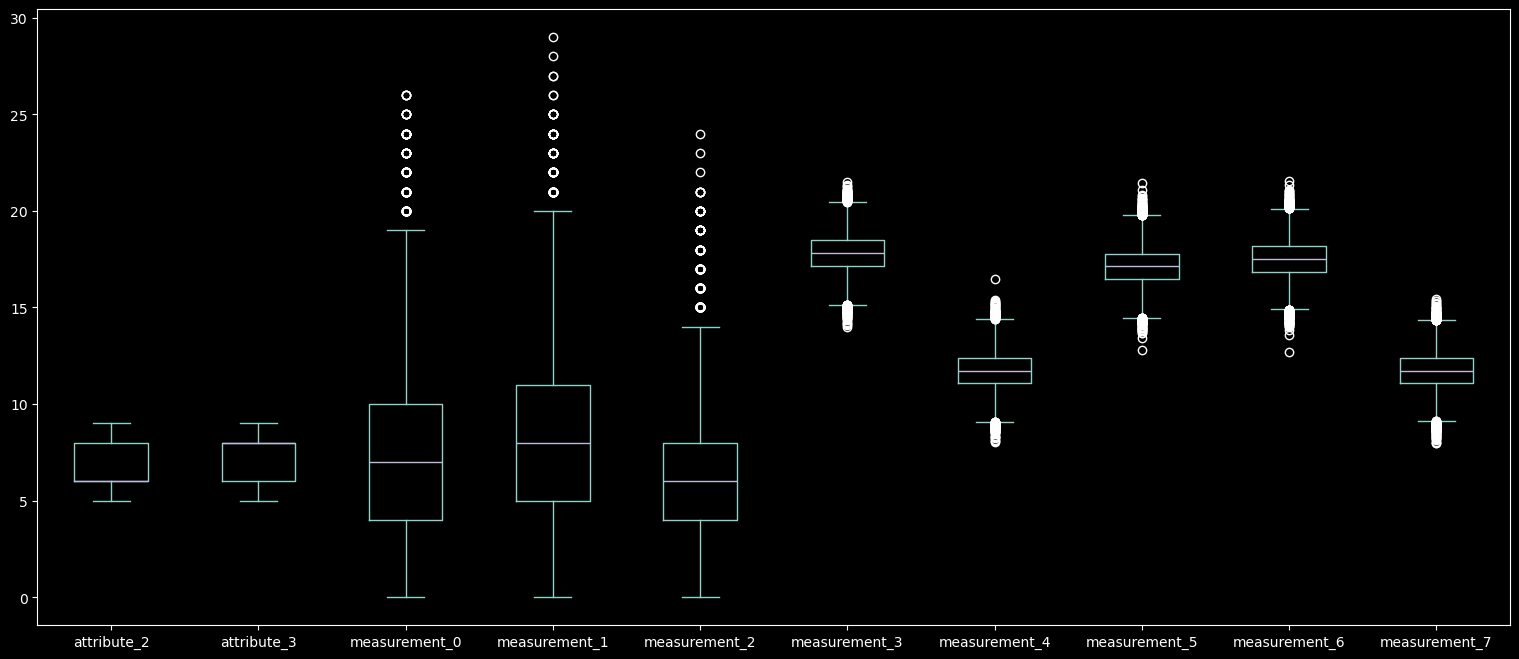

In [8]:
X_train[selected_features].plot.box(figsize=(19, 8))

# Optimization plan

[ ] Undersample the data to a small subset

[ ] Standardize the data with StandardScaler

[ ] Remove outliers

[ ] Use SFS to select the top k features

[ ] Plot the correlation matrix and remove highly correlated features

[ ] Switch to using the larger oversampled data

[ ] Use LogisticRegressionCV to find the best hyperparameters

[ ] Make predictions on the test set

[ ] Create a submission file

<Axes: >

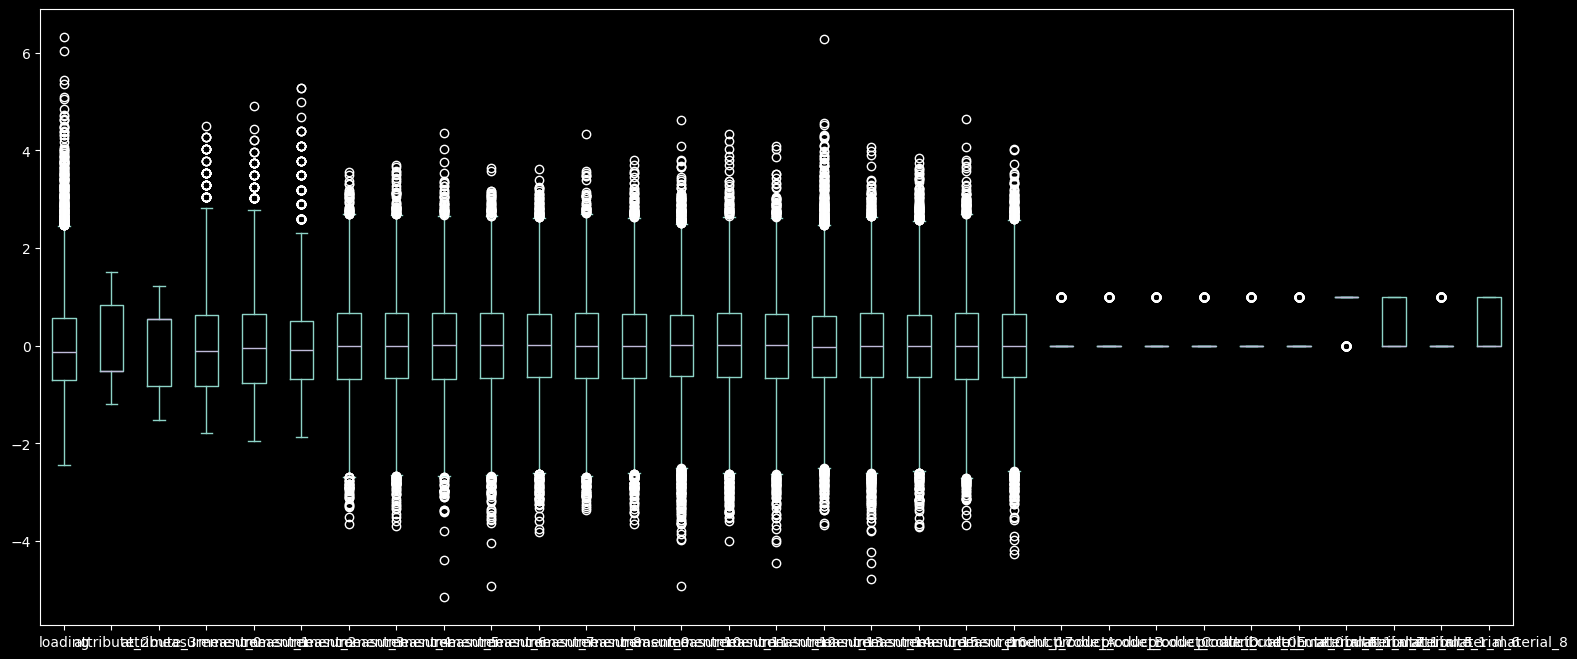

In [9]:
X, y = train_df.drop(['id', 'failure'], axis=1), train_df['failure']

# Use random undersampling to get a smaller dataset
rus = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = rus.fit_resample(X, y)

# Handle categorical variables with one-hot encoding
categorical_features = ['product_code', 'attribute_0', 'attribute_1']
numeric_features = [col for col in X_undersampled.columns if col not in categorical_features]

numeric_pipeline = Pipeline(steps=[
    ('impute', KNNImputer(n_neighbors=5)),
    ('standardize', StandardScaler())
])

column_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numeric_features),
        ('onehot', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_transformed = pd.DataFrame(column_transformer.fit_transform(X_undersampled), columns=column_transformer.get_feature_names_out())

# Plot the boxplots of the transformed data
X_transformed.plot.box(figsize=(19, 8))


array([[<Axes: xlabel='loading', ylabel='loading'>,
        <Axes: xlabel='attribute_2', ylabel='loading'>,
        <Axes: xlabel='attribute_3', ylabel='loading'>,
        <Axes: xlabel='measurement_0', ylabel='loading'>,
        <Axes: xlabel='measurement_1', ylabel='loading'>,
        <Axes: xlabel='measurement_2', ylabel='loading'>,
        <Axes: xlabel='measurement_3', ylabel='loading'>,
        <Axes: xlabel='measurement_4', ylabel='loading'>,
        <Axes: xlabel='measurement_5', ylabel='loading'>,
        <Axes: xlabel='measurement_6', ylabel='loading'>,
        <Axes: xlabel='measurement_7', ylabel='loading'>,
        <Axes: xlabel='measurement_8', ylabel='loading'>,
        <Axes: xlabel='measurement_9', ylabel='loading'>,
        <Axes: xlabel='measurement_10', ylabel='loading'>,
        <Axes: xlabel='measurement_11', ylabel='loading'>,
        <Axes: xlabel='measurement_12', ylabel='loading'>,
        <Axes: xlabel='measurement_13', ylabel='loading'>,
        <Axes: xlabe

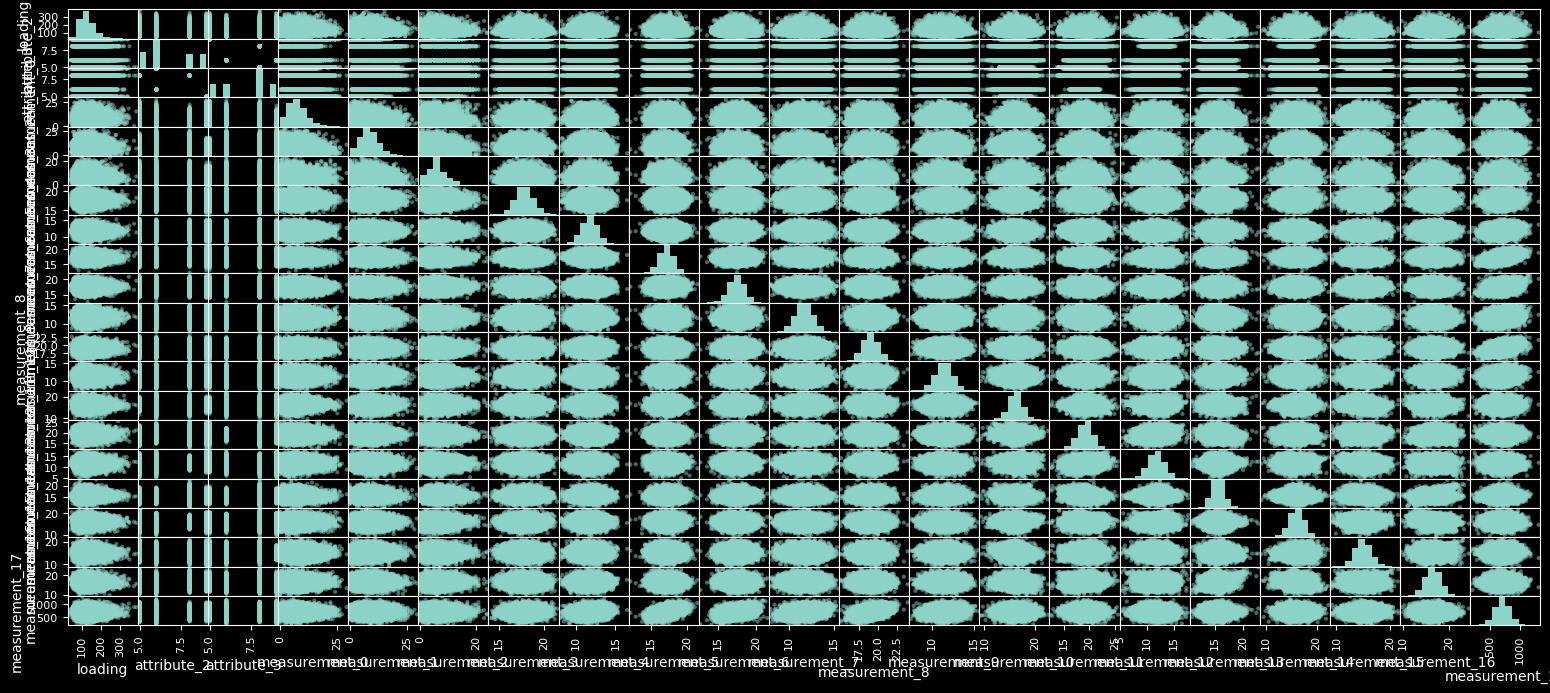

In [10]:
scatter_matrix(X, figsize=(19, 8))

Selected features: Index(['loading', 'measurement_4', 'measurement_7', 'measurement_9',
       'measurement_17'],
      dtype='object')


array([[<Axes: xlabel='loading', ylabel='loading'>,
        <Axes: xlabel='measurement_4', ylabel='loading'>,
        <Axes: xlabel='measurement_7', ylabel='loading'>,
        <Axes: xlabel='measurement_9', ylabel='loading'>,
        <Axes: xlabel='measurement_17', ylabel='loading'>,
        <Axes: xlabel='failure', ylabel='loading'>],
       [<Axes: xlabel='loading', ylabel='measurement_4'>,
        <Axes: xlabel='measurement_4', ylabel='measurement_4'>,
        <Axes: xlabel='measurement_7', ylabel='measurement_4'>,
        <Axes: xlabel='measurement_9', ylabel='measurement_4'>,
        <Axes: xlabel='measurement_17', ylabel='measurement_4'>,
        <Axes: xlabel='failure', ylabel='measurement_4'>],
       [<Axes: xlabel='loading', ylabel='measurement_7'>,
        <Axes: xlabel='measurement_4', ylabel='measurement_7'>,
        <Axes: xlabel='measurement_7', ylabel='measurement_7'>,
        <Axes: xlabel='measurement_9', ylabel='measurement_7'>,
        <Axes: xlabel='measurement_17'

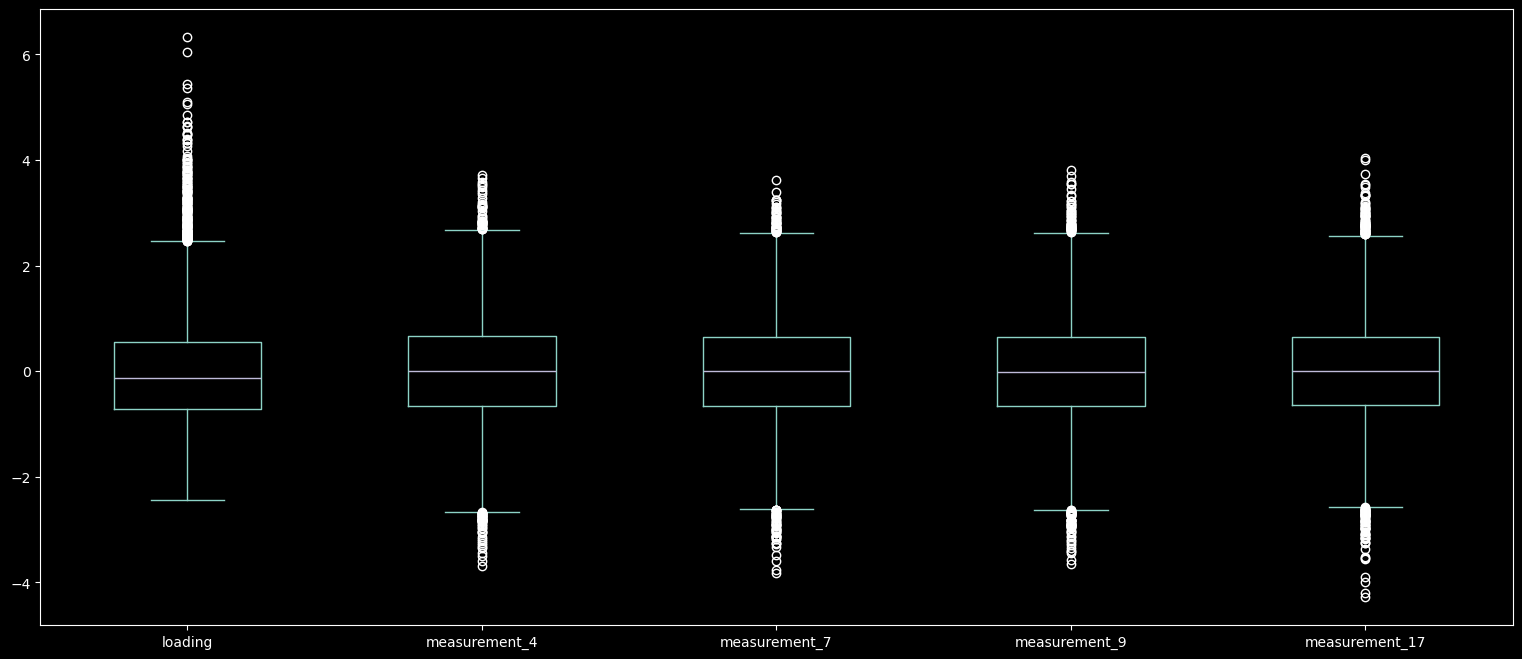

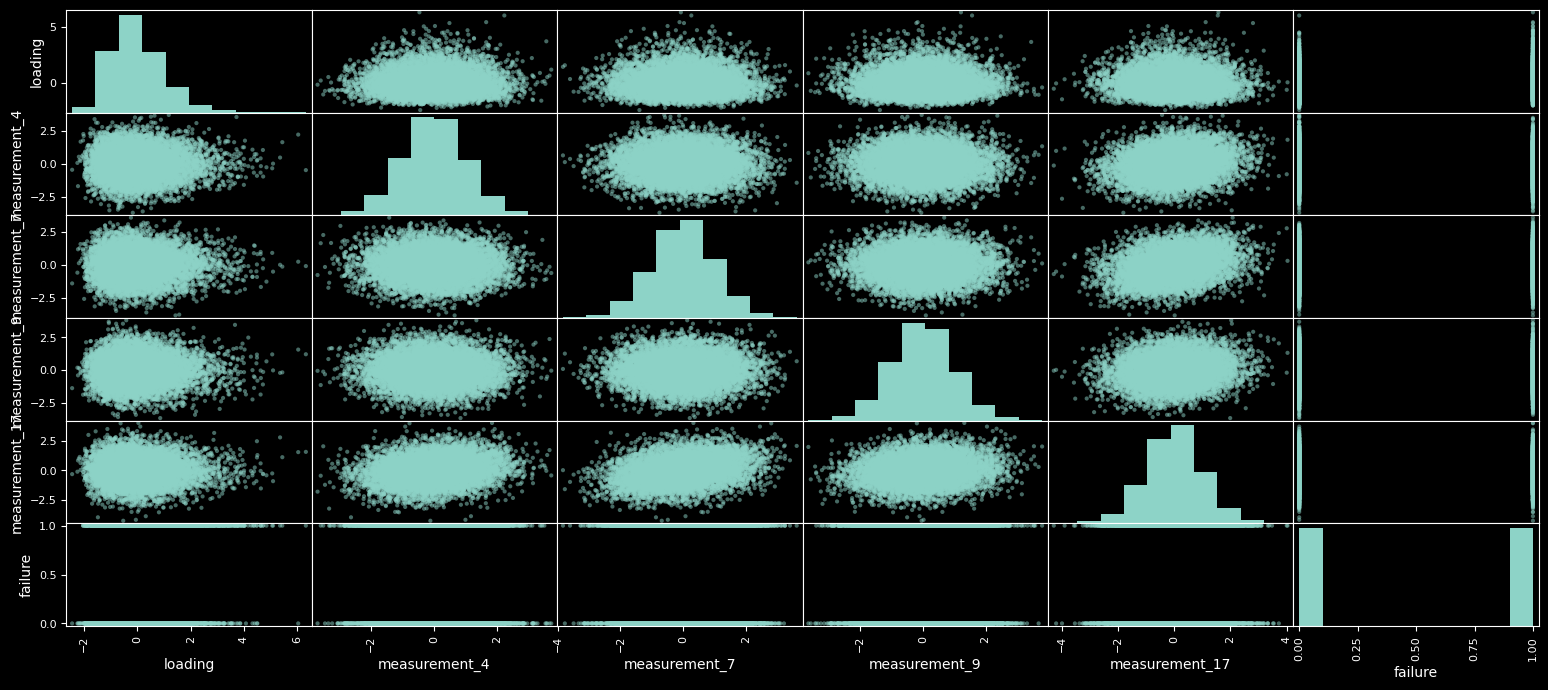

In [11]:
# Use SFS to select the top k features
sfs = SequentialFeatureSelector(LogisticRegression(random_state=42), n_features_to_select=5, direction='forward', scoring='roc_auc')
sfs.fit(X_transformed, y_undersampled)

# Get the selected features
selected_features = X_transformed.columns[sfs.get_support()]

X_selected = X_transformed[selected_features]

print("Selected features:", selected_features)

# Plot the boxplots of the transformed data
X_selected.plot.box(figsize=(19, 8))

# Combine X_selected with y_undersampled
X_selected_with_y = pd.concat([X_selected, y_undersampled.reset_index(drop=True)], axis=1)

# Create the scatter matrix including the target variable
scatter_matrix(X_selected_with_y, figsize=(19, 8))

In [12]:
# Use RandomOverSampler to oversample the data
ros = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = ros.fit_resample(X, y)
print(f"Columns of X: {X.columns}")
print(f"Shape of X_oversampled: {X_oversampled.shape}")
print(f"Shape of y_oversampled: {y_oversampled.shape}")

print(f"Selected features: {selected_features}")

X_selected_oversampled = X_oversampled[selected_features]

# Use LogisticRegressionCV to find the best hyperparameters
lr_cv = LogisticRegressionCV(cv=5, Cs=Cs, scoring='roc_auc', random_state=42, max_iter=1000)
pipeline = Pipeline(steps=[('preprocessor', numeric_pipeline), ('classifier', lr_cv)])

# Fit the model on the training data
pipeline.fit(X_selected_oversampled, y_oversampled)

# Print the best hyperparameters
print(f"\nBest hyperparameters: {lr_cv.C_}")

Columns of X: Index(['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2',
       'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2',
       'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
       'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
       'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
       'measurement_15', 'measurement_16', 'measurement_17'],
      dtype='object')
Shape of X_oversampled: (41842, 24)
Shape of y_oversampled: (41842,)
Selected features: Index(['loading', 'measurement_4', 'measurement_7', 'measurement_9',
       'measurement_17'],
      dtype='object')

Best hyperparameters: [0.00069519]


In [13]:
# Prepare the final validation data (test_df)
X_final = test_df.drop('id', axis=1)

X_final_selected = X_final[selected_features]

print(f"Shape of X_final: {X_final_selected.shape}")

# Make predictions on the final validation data
final_predictions = pipeline.predict(X_final_selected)

# Create a submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'failure': final_predictions
})

# Save the submission file
submission.to_csv('logistic_regression_submission.csv', index=False)
print("\nSubmission file created: logistic_regression_submission.csv")

Shape of X_final: (20775, 5)

Submission file created: logistic_regression_submission.csv
